In [1]:
import os
from os import environ
environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
environ['CUDA_VISIBLE_DEVICES'] = '1' #Select the GPU Card
print('Process id: ',os.getpid())


from os.path import dirname, abspath
from os import listdir
import os, os.path, time
import time as time
import timeit

from sys import argv
import sys



########### Load Keras Modules Needed ==========================================
import tensorflow as tf
import tensorflow.keras
# import tensorflow.keras.backend as K

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, \
                                    concatenate, average, add, Reshape, Permute, Conv2D, \
                                    Conv2DTranspose, SeparableConv2D,PReLU, ELU, \
                                    BatchNormalization, \
                                    MaxPooling2D, ZeroPadding2D, UpSampling2D, \
                                    AveragePooling2D,Cropping2D, \
                                    Flatten, Dense, Dropout, Activation, Reshape,\
                                    SpatialDropout2D,Average


from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,\
                            LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model,to_categorical,Sequence



# Load other functions ==================================================
import glob

import numpy as np
from numpy import zeros, newaxis
import h5py, pickle
from random import randint, choice, shuffle, sample
from itertools import product

from ipywidgets import interact, interactive, fixed #interact_manualten
import ipywidgets as widgets
from scipy import signal

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import shutil


Process id:  878785


2025-08-17 07:22:08.513935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-17 07:22:08.526088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755415328.540833  878785 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755415328.545284  878785 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 07:22:08.559895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[0 1 2]


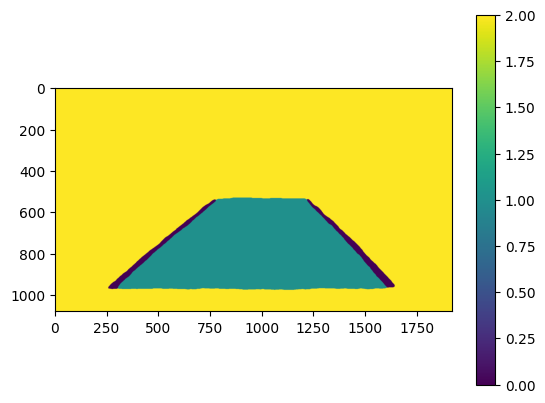

In [2]:
img = np.array(Image.open('./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/all_pink/image_000000.labels.tif'))

img[img==0]=0
img[img==1]=0
img = img-2
print(np.unique(img))
plt.imshow(img)
plt.colorbar()

In [3]:
testname="RailwayMiddleVideoSegmentation_1"

In [4]:
imgpath = "./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/"


img_list = sorted(glob.glob(imgpath+'original_top_half_black_bw/*.png'))
label_list = sorted(glob.glob(imgpath+'all_pink/*.tif'))
print(len(img_list))
print(len(label_list))

print(img_list[0])
print(label_list[0])


50
50
./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/original_top_half_black_bw/image_000000.png
./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/all_pink/image_000000.labels.tif


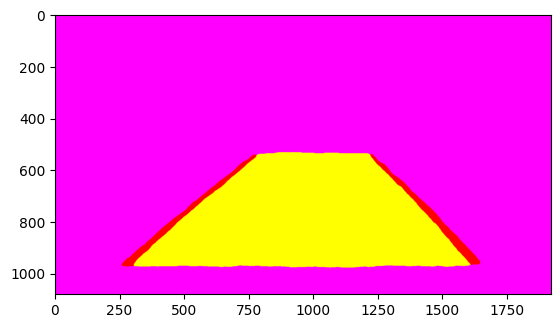

[2 3 4]


In [5]:
import matplotlib.image as mpimg


img=Image.open(label_list[0])
plt.imshow(img)
plt.show()

print(np.unique(img))


In [6]:
Raw_img = []
Label_img = []

### list of new images
for i in range(len(img_list)):
    img =  np.array(Image.open(img_list[i]).convert('L').resize((400,200)), dtype = np.uint8)

    img = (img-np.min(img))/(np.max(img)-np.min(img)) 
    Raw_img.append(img)

    temp_name = (img_list[i].split('/')[-1]).split('.')[0]+'.labels.tif'
    l_img = np.array(Image.open(imgpath+'all_pink/' + temp_name).convert('L').resize((400,200)), dtype = np.uint8)
    Label_img.append(l_img)


Raw_img = np.asarray(Raw_img)
Label_img = np.asarray(Label_img)

print("number of new images and labels: ",np.shape(Raw_img), np.shape(Label_img))

number of new images and labels:  (50, 200, 400) (50, 200, 400)


[0 1 2]


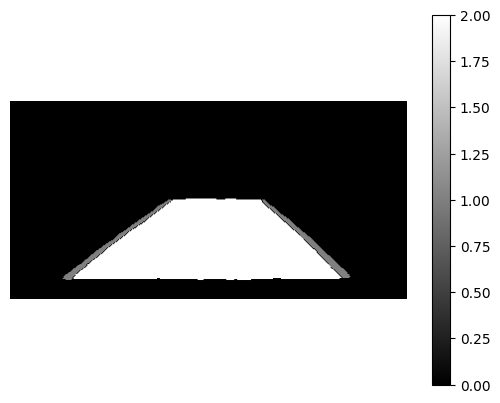

In [7]:
# Label_img_1 = np.copy(Label_img)
# Label_img_1[Label_img_1<125] = 0
# Label_img_1[Label_img_1>=125 & Label_img_1<200] = 1
# Label_img_1[Label_img_1>=200] = 2


# print(np.unique(Label_img_1))
# print(np.shape(Label_img_1))
# plt.imshow(Label_img_1[0])
Label_img_1 = np.copy(Label_img)
# Label_img_1[Label_img_1 < 125] = 0
# Label_img_1[(Label_img_1 >= 125) & (Label_img_1 < 200)] = 1


Label_img_1[Label_img_1 >= 200] = 2
Label_img_1[(Label_img_1 >= 100) & (Label_img_1 < 200)] = 0
Label_img_1[(Label_img_1 >= 5) & (Label_img_1 <=100)] = 1



print(np.unique(Label_img_1))
plt.imshow(Label_img_1[0],cmap='gray')
plt.axis('off')
plt.colorbar()


In [8]:
Label_img = np.copy(Label_img_1)
print(np.shape(Label_img))

(50, 200, 400)


In [9]:
@interact(x=(0,len(Raw_img)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
#     print(OCT_list[x].split('/')[-1])
    f = plt.figure(figsize=(12,6))

    f.add_subplot(1,3, 1)
    plt.imshow(Raw_img[x], cmap='gray')

    f.add_subplot(1,3, 2)
    # color_label= process_label(Label_img[x]+1)
    plt.imshow(Label_img[x])

    f.add_subplot(1,3, 3)
    plt.imshow(Raw_img[x], cmap="gray")
    plt.imshow(Label_img[x],alpha=0.25)
    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=49), Output()), _dom_classes=('widget-interact',…

In [10]:
### shuffle new images
zipimgs=list(zip(Raw_img,Label_img)) #zip the labels  and image data
shuffle(zipimgs) #shuffle the data
Raw_img1,Label_img1=zip(*zipimgs)

print("number of new images and labels: ",np.shape(Raw_img1), np.shape(Label_img1))

Label_img_exp = to_categorical(Label_img1)
print("number of new images and labels after exp: ",np.shape(Raw_img1), np.shape(Label_img_exp))


number of new images and labels:  (50, 200, 400) (50, 200, 400)
number of new images and labels after exp:  (50, 200, 400) (50, 200, 400, 3)


In [11]:
 def process_label(label_file):
        """
        This fucntion takes label files with layers marked from 1 to 8, not 0 to 7
        """
        colors = np.zeros((12,3),dtype=np.uint8)

        #### colors for each label edit accordingly
        colors[0] = [0, 0, 0]
        colors[1] = [255,0,0]
        colors[2] = [0,255,0]
        colors[3] = [0,0,255]
        colors[4] = [255,255,0]
        colors[5] = [255,0,255]
        colors[6] = [0, 255, 255]
        colors[7] = [255, 153, 51]
        colors[8] = [255, 100, 10]
        colors[9] = [255, 50, 100]
        colors[10]= [50, 50, 50]
        colors[11]= [255, 255, 255]

        H = np.shape(label_file)[0]
        W = np.shape(label_file)[1]

        img = np.zeros((H,W,3),dtype=np.uint8)
        for i,j in product(range(H),range(W)):
            img[i, j] = colors[label_file[i,j]-1]

        return np.asarray(img)

In [12]:
@interact(x=(0,len(Raw_img1)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
#     print(OCT_list[x].split('/')[-1])
    f = plt.figure(figsize=(12,6))

    f.add_subplot(1,3, 1)
    plt.imshow(Raw_img1[x], cmap='gray')

    f.add_subplot(1,3, 2)
    color_label= process_label(np.argmax(Label_img_exp[x], axis=2)+1)
    plt.imshow(color_label)

    f.add_subplot(1,3, 3)
    plt.imshow(Raw_img1[x], cmap="gray")
    plt.imshow(color_label,alpha=0.2)
    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=49), Output()), _dom_classes=('widget-interact',…

In [13]:
no_train_images=30 # Number of training images
no_test_images=10#Number of testing images
no_val_images=10 # Number of images in the validation set


W, H = 400,200 #dimension of each image from the cirrus device
nb_classes=3  #11 Layers

In [14]:
train_imgs  =Raw_img1[0:30]
train_labels=Label_img_exp[0:30]

val_imgs  =Raw_img1[30:40]
val_labels=Label_img_exp[30:40]

test_imgs  =Raw_img1[40:]
test_labels=Label_img_exp[40:]

train_images=np.expand_dims(train_imgs,axis=3)
val_images=np.expand_dims(val_imgs,axis=3)
test_images=np.expand_dims(test_imgs,axis=3)

print('\nTraining data dimension: {} for labels and {} for images'.format(np.shape(train_labels),np.shape(train_images)))
print('\nValidation data dimension: {} for labels and {} for images'.format(np.shape(val_labels),np.shape(val_images)))
print('\nTesting data dimension: {} for labels and {} for images'.format(np.shape(test_labels),np.shape(test_images)))


Training data dimension: (30, 200, 400, 3) for labels and (30, 200, 400, 1) for images

Validation data dimension: (10, 200, 400, 3) for labels and (10, 200, 400, 1) for images

Testing data dimension: (10, 200, 400, 3) for labels and (10, 200, 400, 1) for images


In [15]:
def DataGen(X, y, batch_sz,mode):
    alpha, alpha2, sigma = 10, 15, 50
    #alpha, alpha2, sigma = 0, 0, 60

    c = list(zip(X, y))
    croph, cropw = H,W

    shape = X[0].shape[:2]
    x_mesh, y_mesh = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    Xpatches = np.ndarray((batch_sz, croph, cropw, 1), dtype=np.float32)
    ypatches = np.ndarray((batch_sz, croph, cropw, nb_classes), dtype=np.float32)

    #create a mask for later purposes
    black_dx = 60
    black_dy = 20
    dark_mask = np.zeros((black_dx, black_dy))
    for k in range(black_dy):
        dark_mask[:,k] = (np.abs(k-black_dy//2) / (black_dy/2.))**2

    image_index = 0
    batch_index = 0
    while (mode==True):
        #if the batch is full, release the batch
        if batch_index == batch_sz:
            batch_index = 0
            yield Xpatches, ypatches

        if image_index >= len(X):
            image_index = 0

        #do the following at the start of each epoch
        if image_index == 0:
            #shuffle the data
            shuffle(c)
            X, y = zip(*c)
            #below is used once per epoch for the elastic deformation
            g_1d = signal.windows.gaussian(300, sigma)
            kernel_deform = np.outer(g_1d, g_1d)
            dx = signal.fftconvolve(np.random.rand(*shape) * 2 - 1, kernel_deform, mode='same')
            dy = signal.fftconvolve(np.random.rand(*shape) * 2 - 1, kernel_deform, mode='same')
            dx = alpha * (dx - np.mean(dx)) / np.std(dx)
            dy = alpha2 * (dy - np.mean(dy))/ np.std(dy)
            indices_x, indices_y = x_mesh+dx, y_mesh+dy
            indices_x_clipped = np.clip(indices_x, a_min=0, a_max=shape[1]-1)
            indices_y_clipped = np.clip(indices_y, a_min=0, a_max=shape[0]-1)


        #img_height, img_width = X[image_index].shape[:-1]
        ax, ay = np.copy(X[image_index]), np.copy(y[image_index])

        #flip with probability 1/2
        if randint(0, 1):
            ax = ax[:, ::-1, :]
            ay = ay[:, ::-1, :]

        #Intensity nonlinear shift
        if True:
            p = np.random.uniform(low=0.6, high=1.4)
            ax[:,:,0] = ax[:,:,0]**p
            a = np.random.uniform(low=0, high=0.1)
            b = np.random.uniform(low=0, high=0.1)
            ax[:,:,0] = -a + (1+a+b) * ax[:,:,0]
            ax = np.clip(ax, 0., 1.)

        #add black boxes
        if True:
            for k in range(20):
                black_dx = 60
                black_dy = 20
                black_x, black_y = randint(0, ax.shape[0] -  black_dx), randint(0, ax.shape[1] -  black_dy)
                #ax[black_x:(black_x+black_dx), black_y:(black_y+black_dy), 0] = 0
                intensity_dark = np.random.uniform(low=0.2, high=0.8)
                window_to_darken = ax[black_x:(black_x+black_dx), black_y:(black_y+black_dy), 0]
                ax[black_x:(black_x+black_dx), black_y:(black_y+black_dy), 0] = window_to_darken * (intensity_dark + (1.-intensity_dark)*dark_mask)

        #elastic deformation
        if True:
            ax[:,:,0] = ax[indices_y_clipped.astype(int),indices_x_clipped.astype(int),0]
            for k in range(nb_classes):
                ay[:,:,k] = ay[indices_y_clipped.astype(int),indices_x_clipped.astype(int),k]

        #add Gaussian **multiplicative** noise with variable intensity
        if True:
            intensity_noise = np.random.uniform(low=0, high=0.1)
            ax[:,:,0] = ax[:,:,0]*(1+ intensity_noise*np.random.normal(loc=0, scale=1, size=shape[0]*shape[1]).reshape(shape[0],shape[1]))

        #add Gaussian **additive** noise with variable intensity
        if True:
            intensity_noise = np.random.uniform(low=0, high=0.1)
            ax[:,:,0] = ax[:,:,0]  + intensity_noise*np.random.normal(loc=0, scale=1, size=shape[0]*shape[1]).reshape(shape[0],shape[1])


        if False:
            #Define the noise and avg parameters
            gaussian_noise=0
            white_noise=0
            white_mu=8.0963e-06
            sum_averaging=0
            averaging=1 # no averaging is needed. Averaging is shitty.
            random.seed(1)
            for avg in xrange(averaging):
                speckle_noise=-math.log10(np.random.randint(1,100))
                white_noise=-white_mu*math.log10(np.random.randint(1,100))
                sum_averaging=sum_averaging+speckle_noise*ax[:,:,0]+white_noise

            ax[:,:,0]=1/(averaging)*sum_averaging

        #make sure that pixel intensity is in [0,1] and labels are integers
        ax = np.clip(ax, 0., 1.)
        ay = np.clip(ay, 0., 1.)
        ay = np.rint(ay)

        Xpatches[batch_index] = ax
        ypatches[batch_index] = ay

        batch_index = batch_index + 1
        image_index = image_index + 1

In [16]:
# Generate augmentation
batch_sz = 5
training_gen = DataGen(train_images, train_labels, batch_sz,mode=True)
val_gen = DataGen(val_images, val_labels, batch_sz,mode=False)


im,seg = next(training_gen)
print("Dim(image)=",np.shape(im))
print("Dim(Label)=",np.shape(seg))

Dim(image)= (5, 200, 400, 1)
Dim(Label)= (5, 200, 400, 3)


In [17]:
@interact(x=(0,len(im)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider

    f = plt.figure(figsize=(12,6))

    f.add_subplot(1,3, 1)
    plt.imshow(im[x,:,:,0], cmap='gray')

    f.add_subplot(1,3, 2)
    color_label= process_label(np.argmax(seg[x], axis=2)+1)
    plt.imshow(color_label)

    f.add_subplot(1,3, 3)
    plt.imshow(im[x,:,:,0], cmap="gray")
    plt.imshow(color_label,alpha=0.2)
    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [18]:
def unet(img_rows, img_cols, nb_classes):
    inputs = tf.keras.Input(shape=(img_rows, img_cols, 1))
    conv1 = Conv2D(8, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(8, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(1, 1))(drop4)
    conv5 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(64, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (1,1))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(32, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(16, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(8, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(nb_classes, 1, activation = 'softmax')(conv9)
    model = Model(inputs = [inputs], outputs = [conv10])
    return model

In [19]:
img_rows=H; img_cols=W

#sgd_1=tf.keras.optimizers.legacy.SGD(lr=0.005, momentum=0.05, decay=0.01, nesterov=False)
Adam= tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)  ###............


model = unet(img_rows,img_cols,nb_classes)

model.compile(optimizer = Adam, loss = 'categorical_crossentropy', metrics = ['accuracy']) # ....
# model.compile(optimizer = Adam, loss = jacc_coeff_loss_tissue, metrics = ['accuracy']) # ....


model.summary()

/home/suraj/Suraj_env/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
I0000 00:00:1755415348.516772  878785 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20833 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:ca:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 400,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 400,  │         80 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 400,  │        584 │ conv2d[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 200,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 200,  │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 200,  │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 100,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 100,   │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 100,   │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 25, 50,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 25, 50,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 25, 50,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 50,    │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 50,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 25, 50,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 25, 50,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 50,    │          0 │ conv2d_9[0][0]  

 Total params: 321,723 (1.23 MB)

 Trainable params: 321,723 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#model.load_weights(imgpath+'/Model_checkpoints/best_weights_'+testname+'.hdf5')

best_checkpoint = ModelCheckpoint(
    filepath= imgpath + 'Model_checkpoints/best_weights_' + testname + '.weights.h5',  # Use .weights.h5
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

cur_checkpoint = ModelCheckpoint(
    filepath= imgpath + 'Model_checkpoints/cur_weights_' + testname + '.weights.h5',  # Use .weights.h5
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)

# Define the learning rate scheduler
lrScheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    cooldown=0,
    verbose=1,
    min_lr=1e-7
)

#model.load_weights(imgpath+'/Model_checkpoints/best_weights_'+testname+'.hdf5')


In [21]:
epochs=200

train_mini_batch_sz =4
val_mini_batch_sz = 2
num_train_batches, num_val_batches = 32, 32


In [22]:
training_gen = DataGen(train_images, train_labels,train_mini_batch_sz,mode=True) # if flag is not true, then data augmentation will happen on validation also
val_gen = DataGen(val_images, val_labels, val_mini_batch_sz,mode=True) # if flag is not true, then data augmentation will happen on validation also

steps_epoch=20 #train_images.shape[0] // train_mini_batch_sz
val_steps=20 #val_images.shape[0] // val_mini_batch_sz

fit_history = model.fit(
    x=training_gen,  # Generator for training data
    steps_per_epoch=steps_epoch,
    epochs=epochs,
    validation_data=val_gen,  # Generator for validation data
    validation_steps=val_steps,
    verbose=1,
    callbacks=[best_checkpoint, cur_checkpoint]
)


Epoch 1/200


I0000 00:00:1755415355.892605  878945 service.cc:148] XLA service 0x7f296c002d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755415355.892641  878945 service.cc:156]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-08-17 07:22:36.013237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755415356.457341  878945 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5536 - loss: 0.8884 

I0000 00:00:1755415362.850690  878945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7195 - loss: 0.6228
Epoch 1: val_loss improved from None to 0.38109, saving model to ./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/Model_checkpoints/best_weights_RailwayMiddleVideoSegmentation_1.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.7908 - loss: 0.4642 - val_accuracy: 0.7936 - val_loss: 0.3811
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8424 - loss: 0.2999
Epoch 2: val_loss improved from 0.38109 to 0.36625, saving model to ./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/Model_checkpoints/best_weights_RailwayMiddleVideoSegmentation_1.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8376 - loss: 0.3100 - val_accuracy: 0.8060 - val_loss: 0.3662
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8234 - loss: 0.3586
Epoch 3: val_loss improved from 0.36625 to 0.29870, saving model to ./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/M

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


(0.0, 1.0)

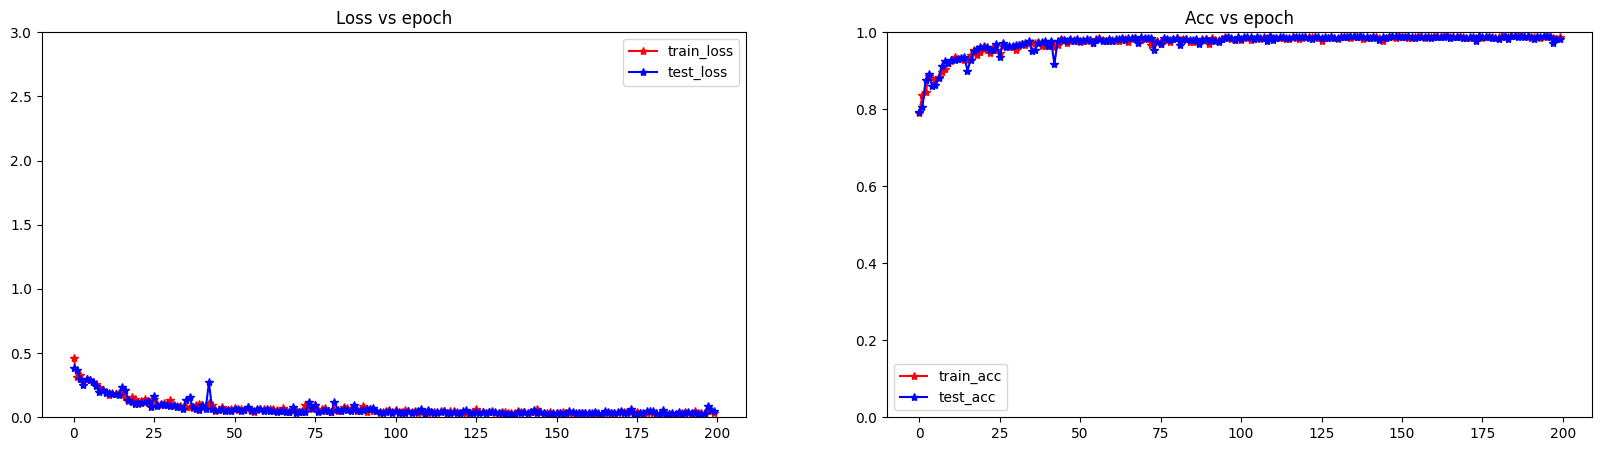

In [23]:
print(fit_history.history.keys())
plt.rcParams['figure.figsize'] = (20,5)

plt.subplot(1,2,1)
plt.title("Loss vs epoch")
plt.plot(fit_history.history["loss"], "r-*", label='train_loss')
plt.plot(fit_history.history["val_loss"], "b-*", label='test_loss')
plt.legend()
plt.ylim(0,3)

plt.subplot(1,2,2)
plt.title("Acc vs epoch")
plt.plot(fit_history.history["accuracy"], "r-*", label='train_acc')
plt.plot(fit_history.history["val_accuracy"], "b-*", label='test_acc')
plt.legend()
plt.ylim(0,1)

In [24]:
model.save( imgpath + '/Model_checkpoints/'+testname+'.h5') # Saving whole model (architecture + weights + optimizer state)
# del model  # deletes the existing model
print('FINISHED!!!!!!!')

FINISHED!!!!!!!


In [47]:
# model2 = load_model('./Model_checkpoints/'+testname+'.h5')
model.load_weights(imgpath + 'Model_checkpoints/best_weights_'+testname+'.weights.h5')
print(imgpath + 'Model_checkpoints/best_weights_'+testname+'.weights.h5')

print('model loaded successfully')

./../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/Model_checkpoints/best_weights_RailwayMiddleVideoSegmentation_1.weights.h5
model loaded successfully


In [26]:
print(np.shape(test_images), np.shape(test_labels))

(10, 200, 400, 1) (10, 200, 400, 3)


In [27]:
test_preds = model.predict(test_images) #obtain predictions for glaucoma

print(np.shape(test_preds))
print('Predictions obtained ....')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(10, 200, 400, 3)
Predictions obtained ....


In [28]:
def DiceCoeff(y_true, y_pred):
    dice = np.zeros(nb_classes)
    for i in range(nb_classes):
        y_pred111 = np.round(y_pred[:,:,i])
        ttt = np.sum(np.minimum(y_true[:,:,i], y_pred111)) / \
                        (np.sum(y_true[:,:,i])+np.sum(y_pred111))
        dice[i] = 2*ttt
    return np.round((np.sum(dice)/nb_classes),2)

0.943 0.01268857754044949


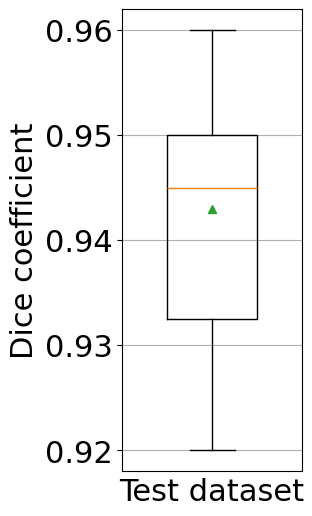

In [29]:
img_data= np.copy(test_images)
label_data= np.copy(test_labels)
label_data2= np.copy(test_preds)

dc_all=np.zeros(len(test_images))
for i in range(len(test_images)):
    dc = DiceCoeff(label_data[i],label_data2[i])
    dc_all[i]=dc

# print(dc_all)
print(np.mean(dc_all),np.std(dc_all))


plt.rcParams.update({'font.size': 22})
f1 = plt.figure(figsize=(6,6))
plt.boxplot(dc_all,patch_artist=False,showmeans=True,showfliers=True,widths=0.5)
plt.grid(True)
plt.ylabel('Dice coefficient')
plt.xlabel('Test dataset')
plt.xticks([])
# plt.ylim(0.75,1)
plt.subplots_adjust(right=0.5,left=0.2)
# plt.savefig('./SegmentationDiceCoefficient' +'.png',dpi=200)
plt.show()

In [30]:
print(np.min(dc_all),np.argmin(dc_all))

0.92 2


In [53]:
@interact(x=(0,len(img_data)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
    f = plt.figure(figsize=(12,6))
    plt.rcParams.update({'font.size': 12})
    f.subplots_adjust(left = 0.02,right = 0.75,wspace = 0.01,hspace = 0.3)

    f.add_subplot(2, 2, 1)
    plt.imshow(img_data[x,:,:,0], cmap='gray')
    plt.axis('off')
    plt.title("Test image")

    f.add_subplot(2, 2, 2)
    color_label= process_label(np.argmax(label_data[x], axis=2)+1)
    plt.imshow(color_label)
    plt.axis('off')
    plt.title("Manual segmentation")

    f.add_subplot(2, 2, 3)
    plt.imshow(img_data[x,:,:,0], cmap='gray')
    plt.imshow(color_label,alpha=0.3)
    plt.axis('off')
    plt.title("Test image with manual segmentation")

    f.add_subplot(2, 2, 4)
    color_label2= process_label(np.argmax(label_data2[x], axis=2)+1)
    plt.imshow(color_label2)
    plt.axis('off')
    plt.title("Network prediction")


    # plt.savefig('./'+str(x) +'.png',dpi=200)

    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=9), Output()), _dom_classes=('widget-interact',)…

Shape: (1, 200, 400, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Test_Preds Shape (1, 200, 400)
(1, 200, 400)
(1080, 1920)
[0 1 2]


Text(0.5, 1.0, 'Test image with manual segmentation')

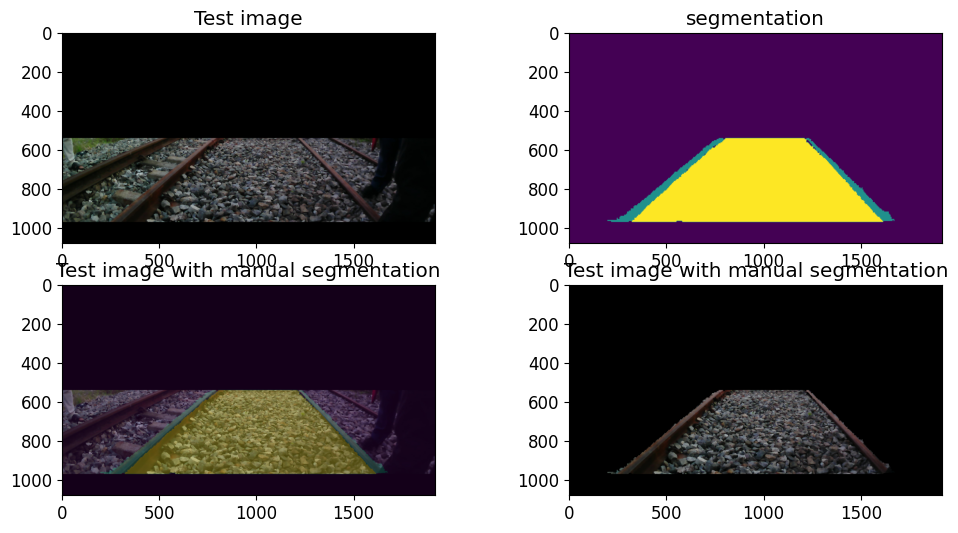

In [54]:
import cv2
path = './../../../../../mnt/DATA/sda1/Suraj/Kunal/segmentation/image_000777_modified.png'
img = Image.open(path)
model=load_model("/mnt/DATA/sda1/Suraj/Kunal/segmentation/Model_checkpoints/RailwayMiddleVideoSegmentation_1.h5")


img_resize = img.convert('L').resize((400,200))
img_np = np.array(img_resize, dtype = np.uint8)
img_np = (img_np-np.min(img_np))/(np.max(img_np)-np.min(img_np)) 
img_np = np.expand_dims(img_np, axis = 0)
img_np = np.expand_dims(img_np, axis = 3)

print("Shape:",np.shape(img_np))

test_preds = model.predict(img_np) #obtain predictions for glaucoma
test_preds = np.argmax(test_preds, axis = 3)


print("Test_Preds Shape",np.shape(test_preds))

test_preds = np.array(test_preds, dtype = np.uint8)
print(np.shape(test_preds))
test_preds_img = Image.fromarray(test_preds[0]).resize((1920,1080))

print(np.shape(test_preds_img))
print(np.unique(test_preds_img))


test_preds_img_modified = np.copy(test_preds_img)
np.array(test_preds_img_modified)
#test_preds_img_modified[test_preds_img_modified==1] = 10

test_preds_img_modified[test_preds_img_modified==0] = 0
test_preds_img_modified[test_preds_img_modified==2] = 1
test_preds_img_modified[test_preds_img_modified==1] = 1


# Blend the image and the mask
img = np.array(img,  dtype = np.uint8)
mask = np.stack((test_preds_img_modified,test_preds_img_modified,test_preds_img_modified), axis = 2)


overlay = np.array(img * mask, dtype = np.uint8)

overlay_img = Image.fromarray(overlay)

name = path.split('/')[-1].split('.')[0] + '_overlay.png'
overlay_img.save('./../../../../../mnt/DATA/sda1/Suraj/Kunal/RGB_overlay/'+name)



f = plt.figure(figsize=(12,6))
f.add_subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Test image")

f.add_subplot(2, 2, 2)
plt.imshow(test_preds_img)
plt.title("segmentation")

f.add_subplot(2, 2, 3)
plt.imshow(img, cmap='gray')
plt.imshow(test_preds_img,alpha=0.3)
plt.title("Test image with manual segmentation")


f.add_subplot(2, 2, 4)
plt.imshow(overlay)
plt.title("Test image with manual segmentation")